In [1]:
import os
import os.path as osp

import time

from PIL import Image
import numpy as np

In [2]:
data_path = osp.join('.', 'data')
pano_path = osp.join(data_path, 'pano2.png')

In [4]:
pano_img = Image.open(pano_path)
pano_img = pano_img.convert('RGB')
pano = np.asarray(pano_img)

In [5]:
from matplotlib.pyplot import imshow
%matplotlib inline

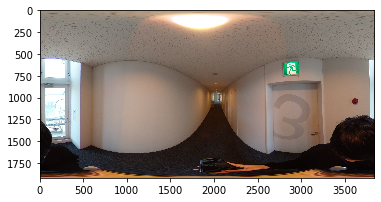

In [6]:
imshow(pano)

## manipulate image

In [7]:
pano.shape

(1920, 3840, 3)

In [8]:
pano = np.transpose(pano, (2,0,1))

In [10]:
channels, h_pano, w_pano = pano.shape
print(channels, h_pano, w_pano)

3 1920 3840


In [23]:
_xs = np.linspace(0, w_pano-1, w_pano)
_ys = np.linspace(0, h_pano-1, h_pano)
xs, ys = np.meshgrid(_xs, _ys)
zs = np.ones_like(xs)
coord = np.stack((xs, ys, zs), axis=2)

In [24]:
coord = coord[:, :, :, np.newaxis]
coord.shape

(1920, 3840, 3, 1)

In [25]:
def create_rot_mat(rot: list) -> np.array:
    r"""param: rot: [yaw, pitch, roll]
    """
    rot_yaw, rot_pitch, rot_roll = rot

    R_yaw = np.array([
        [np.cos(rot_yaw), 0., -np.sin(rot_yaw)],
        [0., 1., 0.],
        [np.sin(rot_yaw), 0., np.cos(rot_yaw)]])
    R_pitch = np.array([
        [1., 0., 0.],
        [0., np.cos(rot_pitch), -np.sin(rot_pitch)],
        [0., np.sin(rot_pitch), np.cos(rot_pitch)]])
    R_roll = np.array([
        [np.cos(rot_roll), -np.sin(rot_roll), 0.],
        [np.sin(rot_roll), np.cos(rot_roll), 0.],
        [0., 0., 1.]])
    R = R_roll @ R_pitch @ R_yaw
    return R

In [26]:
R = create_rot_mat([45, 0, 0])

In [27]:
R_inv = np.linalg.inv(R)

In [28]:
rot_coord = R_inv @ coord

In [29]:
rot_coord = rot_coord.squeeze(3)
rot_coord.shape

(1920, 3840, 3)

In [30]:
def pixel_wise_rot(rot_coord: np.array) -> (np.array, np.array):
    a = np.arctan2(rot_coord[:, :, 0], rot_coord[:, :, 2])
    b = np.arcsin(rot_coord[:, :, 1] / np.linalg.norm(rot_coord, axis=2))
    return a, b

In [32]:
a, b = pixel_wise_rot(rot_coord)

In [33]:
ui = (a + np.pi) * w_pano / (2 * np.pi)
uj = (b + np.pi / 2) * h_pano / np.pi

ui = np.where(ui < 0, ui + w_pano, ui)
ui = np.where(ui >= w_pano, ui - w_pano, ui)
uj = np.where(uj < 0, uj + h_pano, uj)
uj = np.where(uj >= h_pano, uj - h_pano, uj)

In [34]:
grid = np.stack((uj, ui), axis=0)